# 第七章 代理

 - [一、设置OpenAI API Key](#一、设置OpenAI-API-Key)
 - [二、LangChain内置工具](#二、LangChain内置工具)
     - [2.1 使用llm-math和wikipedia工具](#2.1-使用llm-math和wikipedia工具)
     - [2.2 使用PythonREPLTool工具](#2.2-使用PythonREPLTool工具)
 - [三、 定义自己的工具并在代理中使用](#三、-定义自己的工具并在代理中使用)
     - [3.1 创建和使用自定义时间工具](#3.1-创建和使用自定义时间工具)


## 一、设置OpenAI API Key

登陆 [OpenAI 账户](https://platform.openai.com/account/api-keys) 获取API Key，然后将其设置为环境变量。

- 如果你想要设置为全局环境变量，可以参考[知乎文章](https://zhuanlan.zhihu.com/p/627665725)。
- 如果你想要设置为本地/项目环境变量，在本文件目录下创建`.env`文件, 打开文件输入以下内容。

    <p style="font-family:verdana; font-size:12px;color:green">
    OPENAI_API_KEY="your_api_key" 
    </p>
  
  替换"your_api_key"为你自己的 API Key

In [1]:
import os
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

# 读取本地/项目的环境变量。

# find_dotenv()寻找并定位.env文件的路径
# load_dotenv()读取该.env文件，并将其中的环境变量加载到当前的运行环境中  
# 如果你设置的是全局的环境变量，这行代码则没有任何作用。
_ = load_dotenv(find_dotenv())

# 获取环境变量 OPENAI_API_KEY
openai_api_key = os.getenv("OPENAI_API_KEY")

## 二、LangChain内置工具

### 2.1 使用llm-math和wikipedia工具

#### 2.1.1 初始化大语言模型

- 默认密钥`openai_api_key`为环境变量`OPENAI_API_KEY`。因此在运行以下代码之前，确保你已经设置环境变量`OPENAI_API_KEY`。如果还没有密钥，请[获取你的API Key](https://platform.openai.com/account/api-keys) 。
- 默认模型`model_name`为`gpt-4o-mini`。
- 更多关于模型默认参数请查看[这里](https://github.com/hwchase17/langchain/blob/master/langchain/chat_models/openai.py)。

In [2]:
from langchain.chat_models import init_chat_model

# 参数temperature设置为0.0，从而减少生成答案的随机性。
llm = init_chat_model(model="gpt-4o-mini", temperature=0)

#### 2.1.2 加载工具包
- `llm-math` 工具结合语言模型和计算器用以进行数学计算
- `wikipedia`工具通过API连接到wikipedia进行搜索查询。

In [3]:
from langchain.agents import load_tools

tools = load_tools(
    ["llm-math","wikipedia"], 
    llm=llm #第一步初始化的模型
)

#### 2.1.3 <span style="color:#00ff00">新版api</span>

##### 2.1.3.1 初始化代理

<span style="color:#00ff00">
在LangChain的新版本中，我们采用<code>LangGraph</code>框架搭建我们的代理。这里，我们使用预定义的ReAct框架<code>create_react_agent</code>来初始化我们的代理图。
</span>

In [4]:
from langgraph.prebuilt import create_react_agent

graph = create_react_agent(llm, tools=tools)

<span style="color:#00ff00">
可以如下可视化代理图：
</span>

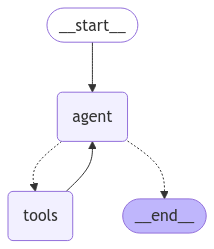

In [40]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

<span style="color:#00ff00">
使用如下流式输出函数打印我们的代理运行结果。
</span>

In [5]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

##### 2.1.3.2 使用代理回答数学问题

In [42]:
question = "计算300的25%。"

inputs = {"messages": [("user", question)]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

计算300的25%。
================================== Ai Message ==================================
Tool Calls:
  Calculator (call_S7fMTAVp3nDGrABFXilYD643)
 Call ID: call_S7fMTAVp3nDGrABFXilYD643
  Args:
    __arg1: 300 * 0.25
================================= Tool Message =================================
Name: Calculator

Answer: 75.0
================================== Ai Message ==================================

300的25%是75。


<span style="color:#00ff00">
可以看到，我们的代理调用了工具<code>calculator</code>，并得到了正确的答案。
</span>

##### 2.1.3.3 Tom M. Mitchell的书

In [43]:
from langchain_core.messages import HumanMessage

question = "Tom M. Mitchell is an American computer scientist \
and the Founders University Professor at Carnegie Mellon University (CMU)\
what book did he write?"

inputs = {"messages": HumanMessage(content=question)}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Tom M. Mitchell is an American computer scientist and the Founders University Professor at Carnegie Mellon University (CMU)what book did he write?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_MaXbaQe54FU3fvATZeo7b2qk)
 Call ID: call_MaXbaQe54FU3fvATZeo7b2qk
  Args:
    query: Tom M. Mitchell
================================= Tool Message =================================
Name: wikipedia

Page: Tom M. Mitchell
Summary: Tom Michael Mitchell (born August 9, 1951) is an American computer scientist and the Founders University Professor at Carnegie Mellon University (CMU). He is a founder and former chair of the Machine Learning Department at CMU. Mitchell is known for his contributions to the advancement of machine learning, artificial intelligence, and cognitive neuroscience and is the author of the textbook Machine Learning. He is a member of 

<span style="color:#00ff00">
可以看到，我们的代理调用了工具<code>wikipedia</code>，并得到了正确的答案。
</span>

#### <span style="color:#00ff00">2.1.3.4 美国总统的名字 </span>

In [9]:
from langchain_core.messages import HumanMessage

question = "Author David Chanoff has collaborated with a U.S. Navy admiral who served as the ambassador to the United Kingdom under which President? Please only answer with the name of the President."

inputs = {"messages": HumanMessage(content=question)}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Author David Chanoff has collaborated with a U.S. Navy admiral who served as the ambassador to the United Kingdom under which President? Please only answer with the name of the President.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_9SK0Aa45Teox61qR6c4hbSdZ)
 Call ID: call_9SK0Aa45Teox61qR6c4hbSdZ
  Args:
    query: David Chanoff
================================= Tool Message =================================
Name: wikipedia

Page: David Chanoff
Summary: David Chanoff (born November 15, 1943, in Philadelphia) is an American author of non-fiction work. His work has typically involved collaborations with the principal protagonist of the work concerned. His collaborators have included Augustus A. White, Joycelyn Elders, Đoàn Văn Toại, William J. Crowe, Ariel Sharon, Kenneth Good and Felix Zandman, among others. He has also written about a wide

/Users/xiaweichun/miniconda3/envs/llm/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/xiaweichun/miniconda3/envs/llm/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

Page: William J. Crowe
Summary: William James Crowe Jr. (January 2, 1925 – October 18, 2007) was a United States Navy admiral and diplomat who served as the 11th chairman of the Joint Chiefs of Staff under Presidents Ronald Reagan and George H. W. Bush, and as the ambassador to the United Kingdom and Chair of the Intelligence Oversight Board under President Bill Clinton.



Page: J. D. Crowe
Summary: James Dee Crowe (August 27, 1937 – December 24, 2021) was an American banjo player and bluegrass band leader. He first became known during his four-year stint with Jimmy Martin in the 1950s. Crowe led the bluegrass group New South from 1971 until his death in 2021.
================================== Ai Message ==================================

Bill Clinton


<span style="color:#00ff00">
可以看到，我们的代理多次调用了工具<code>wikipedia</code>，并得到了正确的答案。
</span>

#### 2.1.4 <span style="color:#00ff00">旧版api</span>

<span style="color:#00ff00">
在旧版api中，使用的<code>initialize_agent</code>函数将不再更新以支持未来的功能。
</span>



##### 2.1.4.1 初始化代理

- `agent`: 代理类型。这里使用的是`AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION`。其中`CHAT`代表代理模型为针对对话优化的模型，`REACT`代表针对REACT设计的提示模版。
- `handle_parsing_errors`: 是否处理解析错误。当发生解析错误时，将错误信息返回给大模型，让其进行纠正。
- `verbose`: 是否输出中间步骤结果。

In [36]:
from langchain.agents import AgentType
from langchain.agents import initialize_agent

agent= initialize_agent(
    tools, #第二步加载的工具
    llm, #第一步初始化的模型
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,  #代理类型
    handle_parsing_errors=True, #处理解析错误
    verbose = True #输出中间步骤
)

##### 2.1.4.2 使用代理回答数学问题

In [37]:
agent.invoke({"input": "计算300的25%。"})



> Entering new AgentExecutor chain...
Thought: 我需要计算300的25%。这可以通过将300乘以0.25来完成。
Action:
```
{
  "action": "Calculator",
  "action_input": "300 * 0.25"
}
```

Observation: Answer: 75.0
Thought:我现在知道300的25%是75。
Final Answer: 75

> Finished chain.


{'input': '计算300的25%。', 'output': '75'}

✅ **总结**

1. 模型对于接下来需要做什么，给出思考（Thought） 
    
   <p style="font-family:verdana; font-size:12px;color:green"> <strong>思考</strong>：我们需要计算300的25%，这个过程中需要用到乘法和除法。</p>

2. 模型基于思考采取行动（Action）
    <p style="font-family:verdana; font-size:12px;color:green"> <strong>行动</strong>: 使用计算器（calculator），输入300*0.25</p>
3. 模型得到观察（Observation）
    <p style="font-family:verdana; font-size:12px;color:green"><strong>观察</strong>：答案: 75.0</p>

4. 基于观察，模型对于接下来需要做什么，给出思考（Thought）
    <p style="font-family:verdana; font-size:12px;color:green"> <strong>思考</strong>: 我们的问题有了答案 </p>

5. 给出最终答案（Final Answer）
     <p style="font-family:verdana; font-size:12px;color:green"> <strong>最终答案</strong>: 75.0 </p>
5. 以字典的形式给出最终答案。

##### 2.1.4.3 Tom M. Mitchell的书

In [38]:
# 由于wikipedia工具只支持英文搜索，因此我们使用英文的question

question = "Tom M. Mitchell is an American computer scientist \
and the Founders University Professor at Carnegie Mellon University (CMU)\
what book did he write?"
agent.invoke({"input": question})



> Entering new AgentExecutor chain...
Thought: I need to find out what book Tom M. Mitchell has written. I will look for information about him and his publications.
Action:
```
{
  "action": "wikipedia",
  "action_input": "Tom M. Mitchell"
}
```

Observation: Page: Tom M. Mitchell
Summary: Tom Michael Mitchell (born August 9, 1951) is an American computer scientist and the Founders University Professor at Carnegie Mellon University (CMU). He is a founder and former chair of the Machine Learning Department at CMU. Mitchell is known for his contributions to the advancement of machine learning, artificial intelligence, and cognitive neuroscience and is the author of the textbook Machine Learning. He is a member of the United States National Academy of Engineering since 2010. He is also a Fellow of the American Academy of Arts and Sciences, the American Association for the Advancement of Science and a Fellow and past president of the Association for the Advancement of Artificial Intellig

{'input': 'Tom M. Mitchell is an American computer scientist and the Founders University Professor at Carnegie Mellon University (CMU)what book did he write?',
 'output': 'Tom M. Mitchell wrote the book "Machine Learning."'}

✅ **总结**

1. 模型对于接下来需要做什么，给出思考（Thought） 
   <p style="font-family:verdana; font-size:12px;color:green"> <strong>思考</strong>：我应该使用维基百科去搜索。</p>

2. 模型基于思考采取行动（Action）
    <p style="font-family:verdana; font-size:12px;color:green"> <strong>行动</strong>: 使用维基百科，输入Tom M. Mitchell</p>
3. 模型得到观察（Observation）
    <p style="font-family:verdana; font-size:12px;color:green"><strong>观测</strong>: 页面: Tom M. Mitchell，页面: Tom Mitchell (澳大利亚足球运动员)</p>

4. 基于观察，模型对于接下来需要做什么，给出思考（Thought）
    <p style="font-family:verdana; font-size:12px;color:green"> <strong>思考</strong>: Tom M. Mitchell写的书是Machine Learning </p>

5. 给出最终答案（Final Answer）
     <p style="font-family:verdana; font-size:12px;color:green"> <strong>最终答案</strong>: Machine Learning </p>
5. 以字典的形式给出最终答案。


值得注意的是，模型每次运行推理的过程可能存在差异，但最终的结果一致。

### 2.2 使用PythonREPLTool工具

#### 2.2.1 <span style="color:#00ff00">新版api</span>

##### 2.2.1.1 创建适用python工具的代理

<span style="color:#00ff00">
我们仍然使用<code>create_react_agent</code>来初始化代理。这里，我们为了使用<code>PythonREPLTool</code>工具，需要将<code>PythonREPLTool</code>包装为<code>Tool</code>对象。

<code>PythonREPLTool</code> 是 LangChain 中的一个工具，主要用于在交互式Python环境中执行代码。适合需要动态执行Python代码的场景，如数据处理、算法测试等。

需要注意的是，由于<code>PythonREPLTool</code>可以执行任意代码，因此在使用时需要谨慎，避免执行不受信任的代码。
</span>

In [84]:
from langchain_core.tools import Tool
from langchain_experimental.tools.python.tool import PythonREPLTool
from langgraph.prebuilt import create_react_agent

# 1. 创建Python REPL工具
python_repl = PythonREPLTool()

# 2. 将Python REPL包装为Tool对象
tools = [
    Tool(
        name="Python_REPL",
        func=python_repl.run,
        description="用于执行Python代码的工具。输入应该是有效的Python命令。如果你想看到某个值的输出，应该使用print()打印出来。"
    )
]

graph = create_react_agent(llm, tools=tools)

##### 2.2.1.2 使用代理将客户名字转换为拼音

In [85]:
customer_list = ["小明","小黄","小红","小蓝","小橘","小绿"]
inputs = {"messages": [("user", f"将这些客户名字转换为拼音并打印输出列表： {customer_list}")]}

print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

将这些客户名字转换为拼音并打印输出列表： ['小明', '小黄', '小红', '小蓝', '小橘', '小绿']
================================== Ai Message ==================================
Tool Calls:
  Python_REPL (call_8797w1jjEimyIfbzNDefQnJY)
 Call ID: call_8797w1jjEimyIfbzNDefQnJY
  Args:
    __arg1: import pypinyin

names = ['小明', '小黄', '小红', '小蓝', '小橘', '小绿']
# 使用pypinyin库将中文名字转换为拼音
pinyin_names = [pypinyin.lazy_pinyin(name) for name in names]
# 将拼音列表转换为字符串形式
pinyin_names_str = ["".join(pinyin) for pinyin in pinyin_names]
print(pinyin_names_str)
================================= Tool Message =================================
Name: Python_REPL

['xiaoming', 'xiaohuang', 'xiaohong', 'xiaolan', 'xiaoju', 'xiaolv']

================================== Ai Message ==================================

客户名字转换为拼音的列表是： `['xiaoming', 'xiaohuang', 'xiaohong', 'xiaolan', 'xiaoju', 'xiaolv']`。


##### 2.2.1.3 使用调试模式

In [80]:
import langchain

langchain.debug=True

In [82]:
graph.invoke(inputs)

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "messages": [
    [
      "user",
      "将这些客户名字转换为拼音并打印输出列表： ['小明', '小黄', '小红', '小蓝', '小橘', '小绿']"
    ]
  ]
}
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
{
  "messages": [
    [
      "user",
      "将这些客户名字转换为拼音并打印输出列表： ['小明', '小黄', '小红', '小蓝', '小橘', '小绿']"
    ]
  ]
}
[chain/start] [chain:LangGraph > chain:__start__ > chain:ChannelWrite<...>] Entering Chain run with input:
{
  "messages": [
    [
      "user",
      "将这些客户名字转换为拼音并打印输出列表： ['小明', '小黄', '小红', '小蓝', '小橘', '小绿']"
    ]
  ]
}
[chain/end] [chain:LangGraph > chain:__start__ > chain:ChannelWrite<...>] s] Exiting Chain run with output:
{
  "messages": [
    [
      "user",
      "将这些客户名字转换为拼音并打印输出列表： ['小明', '小黄', '小红', '小蓝', '小橘', '小绿']"
    ]
  ]
}
[chain/start] [chain:LangGraph > chain:__start__ > chain:ChannelWrite<start:agent>] Entering Chain run with input:
{
  "messages": [
    [
      "user",
      "将这些客户名字转换为拼音并打印输出

{'messages': [HumanMessage(content="将这些客户名字转换为拼音并打印输出列表： ['小明', '小黄', '小红', '小蓝', '小橘', '小绿']", additional_kwargs={}, response_metadata={}, id='28ef3b64-9f9e-4c1b-9f45-8aa91b67abc1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yziHZydfNweNnOiU3v1MXLON', 'function': {'arguments': '{"__arg1":"import pypinyin\\n\\nnames = [\'小明\', \'小黄\', \'小红\', \'小蓝\', \'小橘\', \'小绿\']\\n\\npinyin_names = [pypinyin.lazy_pinyin(name) for name in names]\\n\\n# Flatten the list of lists\\npinyin_names_flat = [\'\'.join(name) for name in pinyin_names]\\n\\nprint(pinyin_names_flat)"}', 'name': 'Python_REPL'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 106, 'prompt_tokens': 116, 'total_tokens': 222, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-20

<span style="color:#00ff00">
如果我们只希望看到最终的代理输出，可以如下从结果中提取。
</span>

In [88]:
langchain.debug=False

result = graph.invoke(inputs)

# 提取最终输出
final_output = result['messages'][-1].content
print(final_output)

客户名字转换为拼音的列表是： `['xiao ming', 'xiao huang', 'xiao hong', 'xiao lan', 'xiao ju', 'xiao lv']`。


#### 2.2.2 <span style="color:#00ff00">旧版api</span>

#### 2.2.2.1 创建pyhon代理

<span style="color:#00ff00">
在旧版api中，我们使用<code>create_python_agent</code>来创建代理。同样指定代理使用的工具为<code>PythonREPLTool</code>。
</span>

In [98]:
from langchain_experimental.agents.agent_toolkits.python.base import create_python_agent
from langchain_experimental.tools.python.tool import PythonREPLTool

llm = init_chat_model(model="gpt-4o", temperature=0)

agent = create_python_agent(
    llm,  #使用前面一节已经加载的大语言模型
    tool=PythonREPLTool(), #使用Python交互式环境工具（REPLTool）
    agent_executor_kwargs={"handle_parsing_errors": True}, #处理解析错误
    verbose=True #输出中间步骤
)

##### 2.2.2.2 使用代理将客户名字转换为拼音

In [99]:
langchain.debug=False

customer_list = ["小明","小黄","小红","小蓝","小橘","小绿"]

agent.invoke({"input": f"将这些客户名字转换为拼音并打印输出列表：{customer_list}"})



> Entering new AgentExecutor chain...
To convert Chinese characters to Pinyin, we can use the `pypinyin` library in Python. I will write a code snippet to convert the given list of names to Pinyin and print the result.

Action: Python_REPL
Action Input:
```python
from pypinyin import pinyin, Style

names = ['小明', '小黄', '小红', '小蓝', '小橘', '小绿']
pinyin_names = [''.join(item) for item in pinyin(names, style=Style.NORMAL)]
print(pinyin_names)
```
Observation: ['xiao', 'ming', 'xiao', 'huang', 'xiao', 'hong', 'xiao', 'lan', 'xiao', 'ju', 'xiao', 'lv']

Thought:The output is not grouped correctly for each name. I need to adjust the code to ensure each name is converted as a whole.

Action: Python_REPL
Action Input:
```python
from pypinyin import pinyin, Style

names = ['小明', '小黄', '小红', '小蓝', '小橘', '小绿']
pinyin_names = [''.join(item) for name in names for item in pinyin(name, style=Style.NORMAL)]
grouped_pinyin_names = [''.join(pinyin(name, style=Style.NORMAL)[0]) for name in names]
print(g

{'input': "将这些客户名字转换为拼音并打印输出列表：['小明', '小黄', '小红', '小蓝', '小橘', '小绿']",
 'output': "The list of customer names converted to Pinyin is: ['xiaoming', 'xiaohuang', 'xiaohong', 'xiaolan', 'xiaoju', 'xiaolv']."}

##### 2.2.2.3 使用调试模式

<span style="color:#00ff00">
具体的模型执行细节因为问题不同略有出入，但是核心逻辑是一样的。
</span>


在调试（debug）模式下再次运行，我们可以把上面的6步分别对应到下面的具体流程
1. 模型对于接下来需要做什么，给出思考（Thought）
    - <p style="font-family:verdana; font-size:12px;color:green"> [chain/start] [1:chain:AgentExecutor] Entering Chain run with input</p>
    - <p style="font-family:verdana; font-size:12px;color:green"> [chain/start] [1:chain:AgentExecutor > 2:chain:LLMChain] Entering Chain run with input</p>
    - <p style="font-family:verdana; font-size:12px;color:green"> [llm/start] [1:chain:AgentExecutor > 2:chain:LLMChain > 3:llm:ChatOpenAI] Entering LLM run with input</p>
    - <p style="font-family:verdana; font-size:12px;color:green"> [llm/end] [1:chain:AgentExecutor > 2:chain:LLMChain > 3:llm:ChatOpenAI] [12.25s] Exiting LLM run with output</p>
    - <p style="font-family:verdana; font-size:12px;color:green">[chain/end] [1:chain:AgentExecutor > 2:chain:LLMChain] [12.25s] Exiting Chain run with output</p>
2. 模型基于思考采取行动（Action), 因为使用的工具不同，Action的输出也和之前有所不同，这里输出的为python代码
    - <p style="font-family:verdana; font-size:12px;color:green"> [tool/start] [1:chain:AgentExecutor > 4:tool:Python REPL] Entering Tool run with input</p>
    - <p style="font-family:verdana; font-size:12px;color:green"> [tool/end] [1:chain:AgentExecutor > 4:tool:Python REPL] [2.2239999999999998ms] Exiting Tool run with output</p>
3. 模型得到观察（Observation）   
    - <p style="font-family:verdana; font-size:12px;color:green"> [chain/start] [1:chain:AgentExecutor > 5:chain:LLMChain] Entering Chain run with input</p>
4. 基于观察，模型对于接下来需要做什么，给出思考（Thought）   
    - <p style="font-family:verdana; font-size:12px;color:green"> [llm/start] [1:chain:AgentExecutor > 5:chain:LLMChain > 6:llm:ChatOpenAI] Entering LLM run with input</p>
    - <p style="font-family:verdana; font-size:12px;color:green"> [llm/end] [1:chain:AgentExecutor > 5:chain:LLMChain > 6:llm:ChatOpenAI] [6.94s] Exiting LLM run with output</p>
    
5. 给出最终答案（Final Answer） 
    - <p style="font-family:verdana; font-size:12px;color:green"> [chain/end] [1:chain:AgentExecutor > 5:chain:LLMChain] [6.94s] Exiting Chain run with output</p>
6. 返回最终答案。
    - <p style="font-family:verdana; font-size:12px;color:green"> [chain/end] [1:chain:AgentExecutor] [19.20s] Exiting Chain run with output</p>

In [100]:
langchain.debug=True

customer_list = ["小明","小黄","小红","小蓝","小橘","小绿"]

agent.invoke({"input": f"将这些客户名字转换为拼音并打印输出列表： {customer_list}"})

[chain/start] [chain:AgentExecutor] Entering Chain run with input:
{
  "input": "将这些客户名字转换为拼音并打印输出列表： ['小明', '小黄', '小红', '小蓝', '小橘', '小绿']"
}
[chain/start] [chain:AgentExecutor > chain:LLMChain] Entering Chain run with input:
{
  "input": "将这些客户名字转换为拼音并打印输出列表： ['小明', '小黄', '小红', '小蓝', '小橘', '小绿']",
  "agent_scratchpad": "",
  "stop": [
    "\nObservation:",
    "\n\tObservation:"
  ]
}
[llm/start] [chain:AgentExecutor > chain:LLMChain > llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "Human: You are an agent designed to write and execute python code to answer questions.\nYou have access to a python REPL, which you can use to execute python code.\nIf you get an error, debug your code and try again.\nOnly use the output of your code to answer the question. \nYou might know the answer without running any code, but you should still run the code to get the answer.\nIf it does not seem like you can write code to answer the question, just return \"I don't know\" as the answe

{'input': "将这些客户名字转换为拼音并打印输出列表： ['小明', '小黄', '小红', '小蓝', '小橘', '小绿']",
 'output': "The list of customer names converted to Pinyin is: ['xiaoming', 'xiaohuang', 'xiaohong', 'xiaolan', 'xiaoju', 'xiaolv']."}

### 2.3 总结

<span style="color:#00ff00">
新版基于LangGraph框架的ReAct代理在执行效果以及可视化方面都比旧版api更加优秀。此外，新版api还支持更多自定义功能。关于新版api框架的预定义代理<code>create_react_agent</code>，可以参考
</span>

[LangGraph Prebuilt Components](https://langchain-ai.github.io/langgraph/reference/prebuilt/)。




## 三、 定义自己的工具并在代理中使用

### 3.1 创建和使用自定义时间工具

In [101]:
# 导入tool函数装饰器
from langchain.agents import tool
from datetime import date

#### 3.2 使用tool函数装饰器构建自定义工具
`tool函数装饰器`可以应用于任何函数，将函数转化为LongChain工具，使其成为<span style="color:red">代理可调用</span>的工具。

我们需要给函数加上<span style="color:red">非常详细的文档字符串</span>, 使得代理知道在什么情况下、如何使用该函数/工具。

比如下面的函数`time`,我们加上了详细的文档字符串

```python
"""
返回今天的日期，用于任何与获取今天日期相关的问题。
输入应该始终是一个空字符串，该函数将始终返回今天的日期。
任何日期的计算应该在此函数之外进行。
"""

```

In [102]:
@tool
def time(text: str) -> str:
    """
    返回今天的日期，用于任何需要知道今天日期的问题。\
    输入应该总是一个空字符串，\
    这个函数将总是返回今天的日期，任何日期计算应该在这个函数之外进行。
    """
    return str(date.today())

In [107]:
llm = init_chat_model(model='gpt-4o-mini', temperature = 0)

### 3.3 <span style="color:#00ff00">新版api</span>

#### 3.3.1 初始化代理

In [108]:
graph = create_react_agent(llm, tools=[time])

#### 3.3.2 使用代理询问今天的日期

In [109]:
inputs = {"messages": [("user", "今天的日期是？")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

今天的日期是？
================================== Ai Message ==================================
Tool Calls:
  time (call_7ODk7mcuC3Zme9S8y19Hm2dF)
 Call ID: call_7ODk7mcuC3Zme9S8y19Hm2dF
  Args:
    text:
================================= Tool Message =================================
Name: time

2025-03-17
================================== Ai Message ==================================

今天的日期是2025年3月17日。


### 3.4 <span style="color:#00ff00">旧版api</span>


#### 3.4.1 初始化代理

In [103]:
agent= initialize_agent(
    tools=[time], #将刚刚创建的时间工具加入代理
    llm=llm, #初始化的模型
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,  #代理类型
    handle_parsing_errors=True, #处理解析错误
    verbose = True #输出中间步骤
)

#### 3.4.2 使用代理询问今天的日期
**注**: 代理有时候可能会出错（该功能正在开发中）。如果出现错误，请尝试再次运行它。

In [106]:
langchain.debug=False

agent("今天的日期是？") 



> Entering new AgentExecutor chain...
Thought: I need to use the time tool to find out today's date.
Action:
```
{
  "action": "time",
  "action_input": ""
}
```

Observation: 2025-03-17
Thought:I now know the final answer.
Final Answer: 今天的日期是2025年3月17日。

> Finished chain.


{'input': '今天的日期是？', 'output': '今天的日期是2025年3月17日。'}

✅ **总结**

1. 模型对于接下来需要做什么，给出思考（Thought） 
   <p style="font-family:verdana; font-size:12px;color:green"> <strong>思考</strong>：我需要使用 time 工具来获取今天的日期</p>

2. 模型基于思考采取行动（Action), 因为使用的工具不同，Action的输出也和之前有所不同，这里输出的为python代码
    <p style="font-family:verdana; font-size:12px;color:green"> <strong>行动</strong>: 使用time工具，输入为空字符串</p>
    
   
3. 模型得到观察（Observation）
    <p style="font-family:verdana; font-size:12px;color:green"><strong>观测</strong>: 2023-07-04</p>
    
   
    
4. 基于观察，模型对于接下来需要做什么，给出思考（Thought）
    <p style="font-family:verdana; font-size:12px;color:green"> <strong>思考</strong>: 我已成功使用 time 工具检索到了今天的日期</p>

5. 给出最终答案（Final Answer）
     <p style="font-family:verdana; font-size:12px;color:green"> <strong>最终答案</strong>: 今天的日期是2023-07-04.</p>
6. 返回最终答案。